{/* cspell:ignore subdag DAGOpNode qargs cargs dag_drawer */}
# Work with DAGs in transpiler passes

In Qiskit, within the transpilation stages, circuits are represented using a DAG. In general, a DAG is composed of vertices (also known as "nodes") and directed edges that connect pairs of vertices in a particular orientation. This representation is stored using `qiskit.dagcircuit.DAGCircuit` objects that are composed of individual `DagNode` objects. The advantage of this representation over a pure list of gates (that is, a netlist) is that the flow of information between operations is explicit, making it easier to make transformation decisions.

This guide demonstrates how to work with DAGs and use them to write custom transpiler passes. It will start with building a simple circuit and examining its DAG representation, then explores basic DAG operations and implements a custom `BasicMapper` pass.

## Build a circuit and examine its DAG

The code snippet below illustrates the DAG by creating a simple circuit that prepares a Bell state and applies an $R_Z$ rotation, depending on the measurement outcome.

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=2.0.0
```
</details>

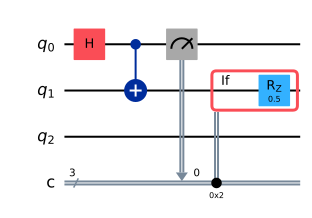

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import circuit_drawer
from qiskit.visualization.dag_visualization import dag_drawer

# Create circuit
q = QuantumRegister(3, "q")
c = ClassicalRegister(3, "c")
circ = QuantumCircuit(q, c)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.measure(q[0], c[0])

# Qiskit 2.0 uses if_test instead of c_if
with circ.if_test((c, 2)):
    circ.rz(0.5, q[1])

circuit_drawer(circ, output="mpl")

In the DAG, there are three kinds of graph nodes: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red). Each edge indicates data flow (or dependency) between two nodes. Use the qiskit.tools.visualization.dag_drawer() function to view this circuit's DAG. (Install the [Graphviz library](https://graphviz.org/download/) to run this.)

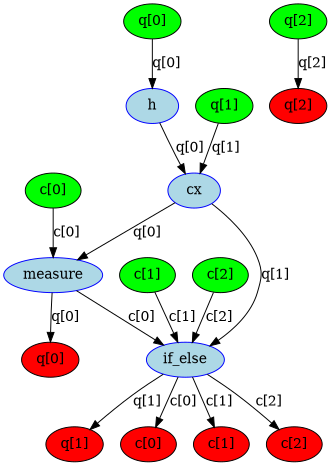

In [2]:
# Convert to DAG
dag = circuit_to_dag(circ)
dag_drawer(dag)

## Basic DAG operations

The code examples below demonstrate common operations with DAGs, including accessing nodes, adding operations, and substituting subcircuits. These operations form the foundation for building transpiler passes.
## Get all operation nodes in the DAG
The `op_nodes()` method returns an iterable list of `DAGOpNode` objects in the circuit:

In [3]:
dag.op_nodes()

[DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(3, "q"), index=0>,), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>), cargs=()),
 DAGOpNode(op=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qargs=(<Qubit register=(3, "q"), index=0>,), cargs=(<Clbit register=(3, "c"), index=0>,)),
 DAGOpNode(op=Instruction(name='if_else', num_qubits=1, num_clbits=3, params=[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7eff295e4990>, None]), qargs=(<Qubit register=(3, "q"), index=1>,), cargs=(<Clbit register=(3, "c"), index=0>, <Clbit register=(3, "c"), index=1>, <Clbit register=(3, "c"), index=2>))]

Each node is an instance of the `DAGOpNode` class:

In [4]:
node = dag.op_nodes()[3]
print("node name:", node.name)
print("op:", node.op)
print("qargs:", node.qargs)
print("cargs:", node.cargs)
print("condition:", node.op.condition)

node name: if_else
op: Instruction(name='if_else', num_qubits=1, num_clbits=3, params=[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7eff295e4990>, None])
qargs: (<Qubit register=(3, "q"), index=1>,)
cargs: (<Clbit register=(3, "c"), index=0>, <Clbit register=(3, "c"), index=1>, <Clbit register=(3, "c"), index=2>)
condition: (ClassicalRegister(3, 'c'), 2)


## Add an operation to the back
An operation is added to the end of the DAGCircuit using the `apply_operation_back()` method. This appends the specified gate to act on the given qubits after all existing operations in the circuit.

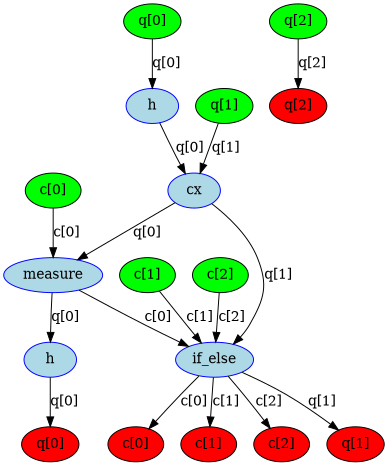

In [5]:
from qiskit.circuit.library import HGate

dag.apply_operation_back(HGate(), qargs=[q[0]])
dag_drawer(dag)

## Add an Operation to the Front
An operation is added to the beginning of the DAGCircuit using the `apply_operation_front()` method. This inserts the specified gate before all existing operations in the circuit, effectively making it the first operation executed.

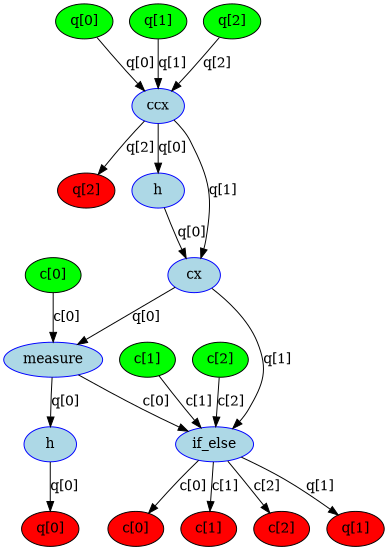

In [6]:
from qiskit.circuit.library import CCXGate

dag.apply_operation_front(CCXGate(), qargs=[q[0], q[1], q[2]])
dag_drawer(dag)

## Substitute a node with a subcircuit
A node representing a specific operation in the DAGCircuit is replaced with a subcircuit. First, a new sub-DAG is constructed with the desired sequence of gates, then the target node is substituted by this sub-DAG using `substitute_node_with_dag()`, preserving the connections to the rest of the circuit.

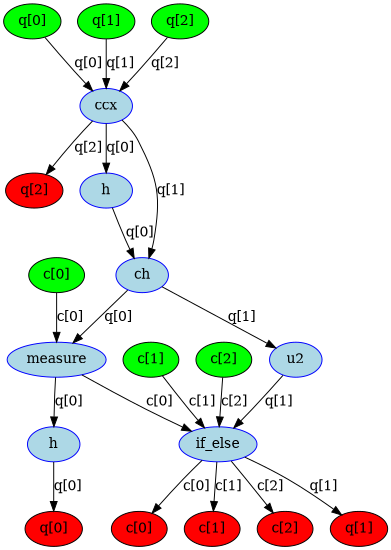

In [7]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit.library import CHGate, U2Gate, CXGate

# Build sub-DAG
mini_dag = DAGCircuit()
p = QuantumRegister(2, "p")
mini_dag.add_qreg(p)
mini_dag.apply_operation_back(CHGate(), qargs=[p[1], p[0]])
mini_dag.apply_operation_back(U2Gate(0.1, 0.2), qargs=[p[1]])

# Replace CX with mini_dag
cx_node = dag.op_nodes(op=CXGate).pop()
dag.substitute_node_with_dag(cx_node, mini_dag, wires=[p[0], p[1]])
dag_drawer(dag)

After all transformations are completed, the DAG can be converted back into a regular `QuantumCircuit` object. This is how the transpiler pipeline operates. A circuit is taken, processed in DAG form, and a transformed circuit is produced as output.

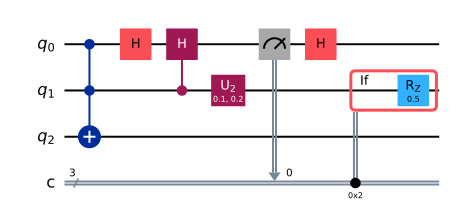

In [8]:
from qiskit.converters import dag_to_circuit

new_circ = dag_to_circuit(dag)
circuit_drawer(new_circ, output="mpl")

## Implement a BasicMapper pass
The DAG structure can be leveraged for writing transpiler passes. In the example below, a `BasicMapper` pass is implemented to map an arbitrary circuit onto a device with restricted qubit connectivity. For additional guidance, refer to the guide on [writing custom transpiler passes](https://docs.quantum.ibm.com/guides/custom-transpiler-pass).

The pass is defined as a `TransformationPass`, meaning that it modifies the circuit. It does so by traversing the DAG layer-by-layer, checking whether each instruction satisfies the constraints imposed by the device's coupling map. If a violation is detected, a swap path is determined and the necessary SWAP gates are inserted accordingly.

When creating a transpiler pass, the first decision involves selecting whether the pass should inherit from `TransformationPass` or `AnalysisPass`. Transformation passes are designed to modify the circuit, whereas analysis passes are intended only to extract information for use by subsequent passes. The main functionality is then implemented in the `run(dag)` method. Finally, the pass should be registered within the `qiskit.transpiler.passes` module.

In this specific pass, the DAG is traversed layer-by-layer (where each layer contains operations that act on disjoint sets of qubits and can thus be executed independently). For each operation, if the coupling map constraints are not met, a suitable swap path is identified, and the required swaps are inserted to bring the involved qubits into adjacency.

In [9]:
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwap(TransformationPass):
    def __init__(self, coupling_map, initial_layout=None):
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)

        if self.initial_layout is None:
            self.initial_layout = Layout.generate_trivial_layout(
                *dag.qregs.values()
            )

        current_layout = self.initial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer["graph"]
            for gate in subdag.two_qubit_ops():
                q0, q1 = gate.qargs
                p0 = current_layout[q0]
                p1 = current_layout[q1]

                if self.coupling_map.distance(p0, p1) != 1:
                    path = self.coupling_map.shortest_undirected_path(p0, p1)
                    for i in range(len(path) - 2):
                        wire1, wire2 = path[i], path[i + 1]
                        qubit1 = current_layout[wire1]
                        qubit2 = current_layout[wire2]
                        new_dag.apply_operation_back(
                            SwapGate(), qargs=[qubit1, qubit2]
                        )
                        current_layout.swap(wire1, wire2)

            new_dag.compose(
                subdag, qubits=current_layout.reorder_bits(new_dag.qubits)
            )

        return new_dag

The pass can now be tested on a small example circuit. A pass manager is constructed with the newly defined pass included. The example circuit is then provided to this pass manager, and a new, transformed circuit is obtained as the output.

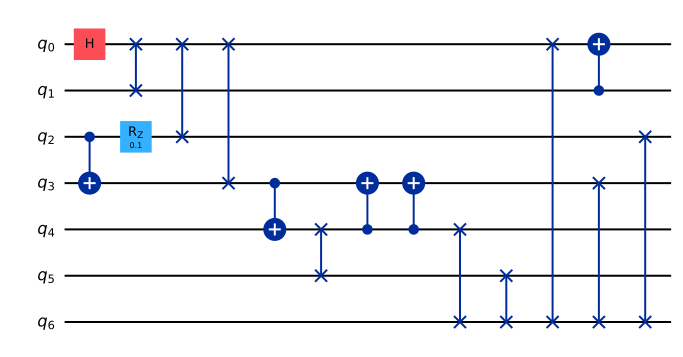

In [10]:
from qiskit.transpiler import CouplingMap, PassManager
from qiskit import QuantumRegister, QuantumCircuit

q = QuantumRegister(7, "q")
in_circ = QuantumCircuit(q)
in_circ.h(q[0])
in_circ.cx(q[0], q[4])
in_circ.cx(q[2], q[3])
in_circ.cx(q[6], q[1])
in_circ.cx(q[5], q[0])
in_circ.rz(0.1, q[2])
in_circ.cx(q[5], q[0])

coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]
coupling_map = CouplingMap(couplinglist=coupling)

pm = PassManager()
pm.append(BasicSwap(coupling_map))

out_circ = pm.run(in_circ)

in_circ.draw(output="mpl")
out_circ.draw(output="mpl")

## Next steps

<Admonition type="tip" title="Recommendations">
    - Review the guide on creating a [custom transpiler pass](./custom-transpiler-pass)
    - Learn how to [transpile against custom backends](./custom-backend)
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - Review the [DAG Circuit API documentation.](../api/qiskit/dagcircuit)
</Admonition>